# 1) Import texts and preprocess 

In [1]:
import pandas as pd
import numpy as np

data = pd.read_excel('ecb_pressconferences.xlsx', header = 0, na_values = 'NaN')
data2 = pd.read_excel('ecb_interviews.xlsx', header=0, na_values = 'NaN')
#data = pd.merge_ordered(data1, data2)
#data = data.sort_values('date', ascending=False)
type(data.text[0])
# data.text[0].count(' ')
data.text[0]


# Example text, latest pressconference in 2017 before preprocessing

"Based on our regular economic and monetary analyses, we decided to keep the key ECB interest rates unchanged. We continue to expect them to remain at their present levels for an extended period of time, and well past the horizon of our net asset purchases.\n\nRegarding non-standard monetary policy measures, we confirm that from January 2018 we intend to continue to make net asset purchases under the asset purchase programme (APP), at a monthly pace of €30 billion, until the end of September 2018, or beyond, if necessary, and in any case until the Governing Council sees a sustained adjustment in the path of inflation consistent with its inflation aim. If the outlook becomes less favourable, or if financial conditions become inconsistent with further progress towards a sustained adjustment in the path of inflation, we stand ready to increase the APP in terms of size and/or duration. The Eurosystem will reinvest the principal payments from maturing securities purchased under the APP for 

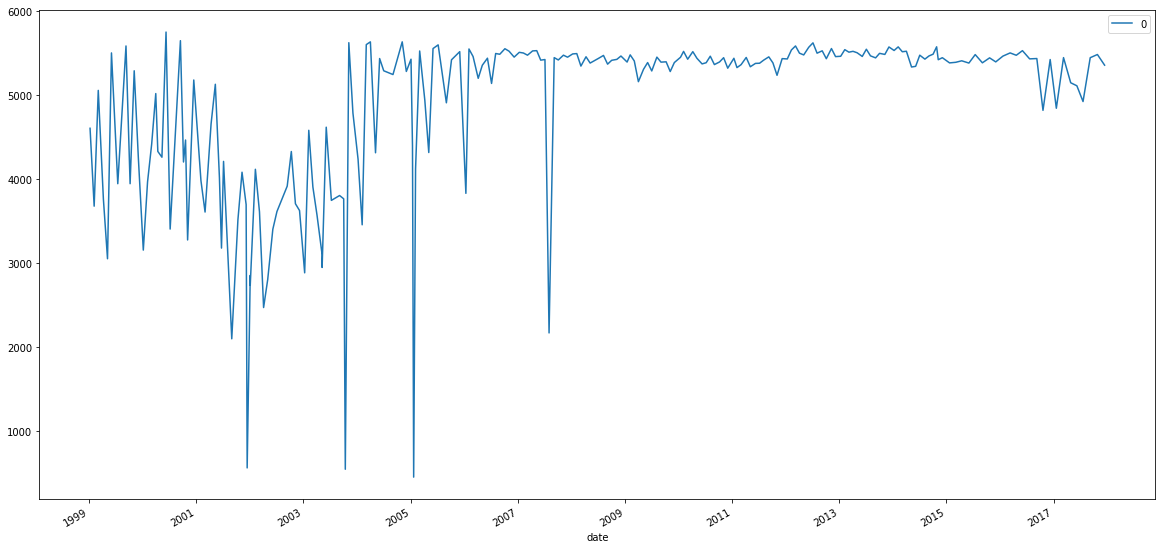

In [4]:
aaa = data.text.tolist()

nr = range(217)
bbb =[]
for x in nr:
    ccc = aaa[x].count(" ")
    
    bbb.append(ccc)
    
# create DataFrame
datum = data.date
ddd = pd.DataFrame(bbb, index = datum)

ddd.plot(kind='line', figsize=(20,10))



In [5]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
import nltk
import string


# preprocessor tokenizes texts first, then strips punctiation, numbers and stopwords (meaningless words) and converts
# entire text to lowercase, Part-of-Speech-tags words to lemmatize subsequently, stem tokens and finally filter for stopwwords
# again. Tokens are joint as a sting and returned.


def preprocessor(clean):
    
    tokens = word_tokenize(clean.lower()) # tokenize text and transform to lowercase
  
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens] # stripped = list
    words = [word for word in stripped if word.isalpha()] # words = list 

    stop_words = set(stopwords.words('english'))
    finterms = pd.read_excel('Finterms_wordlist.xlsx') # include finterm dictionary by Loughran & McDonald (2011)
    for word in set(finterms.get('lm wordlist')):
        stop_words.add(word)
    stop_words = [w.lower() for w in stop_words]

    words_cleaned = [w for w in words if not w in stop_words] # tokens in lowercase that are stripped for punctuation

    def get_wordnet_pos(treebank_tag):

        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return None # for easy if-statement 
    
    lemmatizer = WordNetLemmatizer()
    tagged = nltk.pos_tag(words_cleaned)
    lemmatized = []
    
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:# not supply tag in case of None
            lemma = lemmatizer.lemmatize(word) 
        else:
            lemma = lemmatizer.lemmatize(word, pos=wntag)
        lemmatized.append(lemma)

    ps = PorterStemmer()
    stemmed = []
    for w in lemmatized:
        stemmed.append(ps.stem(w))

    words_preprocessed = [w for w in stemmed if not w in stop_words]
     
    text_preprocessed = " ".join(words_preprocessed)
   
    return text_preprocessed


def dataframe_preprocessor(frame):
   
    for cell in ['text']:
        frame[cell] = frame[cell].apply(preprocessor)
    
    return frame

dataframe_preprocessed = dataframe_preprocessor(data)
dataframe_preprocessed.head()


,date,headline,text,type of publication
0,2017-12-14,"Mario Draghi, Vítor Constâncio: Introductory s...",base regular econom monetari analysi decid kee...,Press conferences in 2017
1,2017-10-26,"Mario Draghi, Vítor Constâncio: Introductory s...",base regular econom monetari analysi today con...,Press conferences in 2017
2,2017-09-07,"Mario Draghi, Vítor Constâncio: Introductory s...",base regular econom monetari analysi decid kee...,Press conferences in 2017
3,2017-07-20,"Mario Draghi, Vítor Constâncio: Introductory s...",base regular econom monetari analysi decid kee...,Press conferences in 2017
4,2017-06-08,"Mario Draghi, Vítor Constâncio: Introductory s...",base regular econom monetari analysi decid kee...,Press conferences in 2017


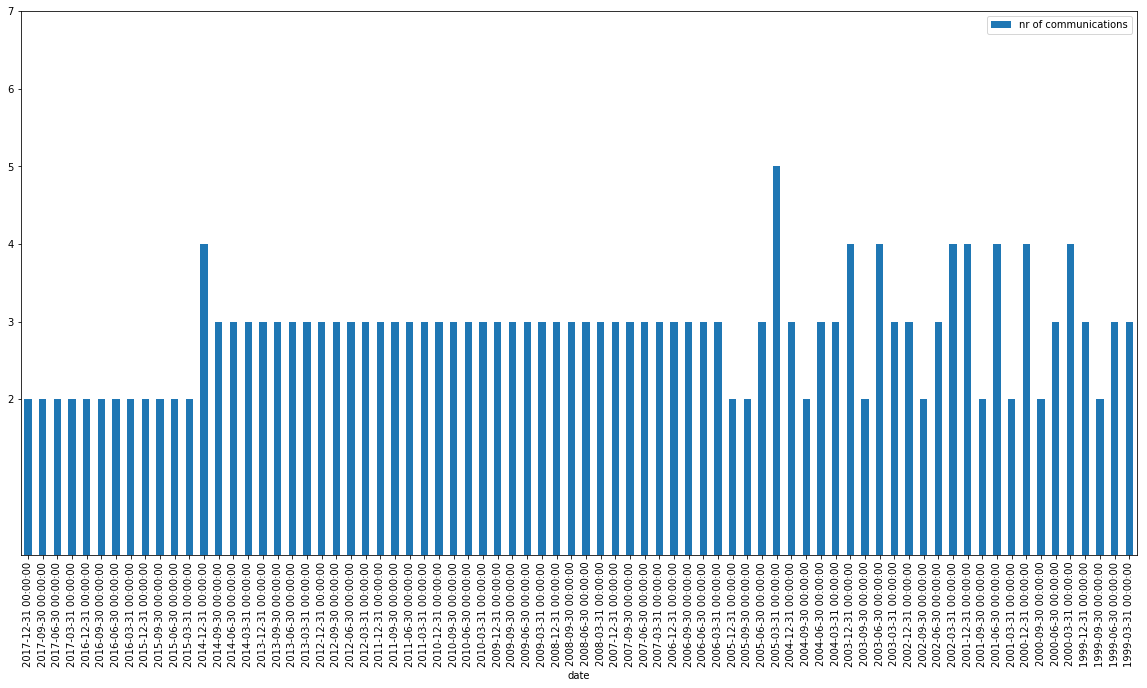

In [6]:
dataframe_preprocessednew = dataframe_preprocessed
dataframe_preprocessednew['nr of communications']= 1

df_preprnew = dataframe_preprocessednew.drop(columns=['headline','text','type of publication'])
df_preprnew['date']=pd.to_datetime(df_preprnew['date'])
df_preprnew=df_preprnew.set_index('date')

df_preprnew = df_preprnew.resample('Q').sum().sort_index(ascending = False)


df_preprnew.plot(kind='bar', yticks=[2,3,4,5,6,7],figsize=(20,10))


# 2) Build corpus and create term-frequency-inverse-document-frequency matrix

In [7]:
corpus = dataframe_preprocessed.text.tolist()
print(type(corpus)) 
print(type(corpus[0]))
print(len(corpus)) 
print(len(corpus[0]))
print(corpus[216].count(" "))
corpus[0]


# Output shows again the latest pressconference in 2017 but this time preprocessed.

# Explain corpus, picture it eg. how many words exist across corpus, most frequent words, distribution (what words in which text?
# how did central bank press conferences develop over time?
# -> number of publications per quarter, word lenght, etc.

<class 'list'>
<class 'str'>
217
14667
1769


'base regular econom monetari analysi decid keep key ecb interest rate unchang continu expect remain present level extend period time well past horizon net asset purchas regard nonstandard monetari polici measur confirm januari intend continu make net asset purchas asset purchas programm app monthli pace billion end septemb beyond necessari case govern council sustain adjust path inflat consist inflat aim outlook becom less favour financi condit becom toward sustain adjust path inflat stand readi increas app term size andor durat eurosystem reinvest princip payment matur secur purchas app extend period time end net asset purchas case long necessari contribut favour liquid condit appropri monetari polici stanc monetari polici decis preserv favour financ condit still need sustain return inflat rate toward level close incom inform includ new staff project indic pace econom expans signific growth outlook cyclic momentum signific reduct econom slack give ground confid inflat converg toward 

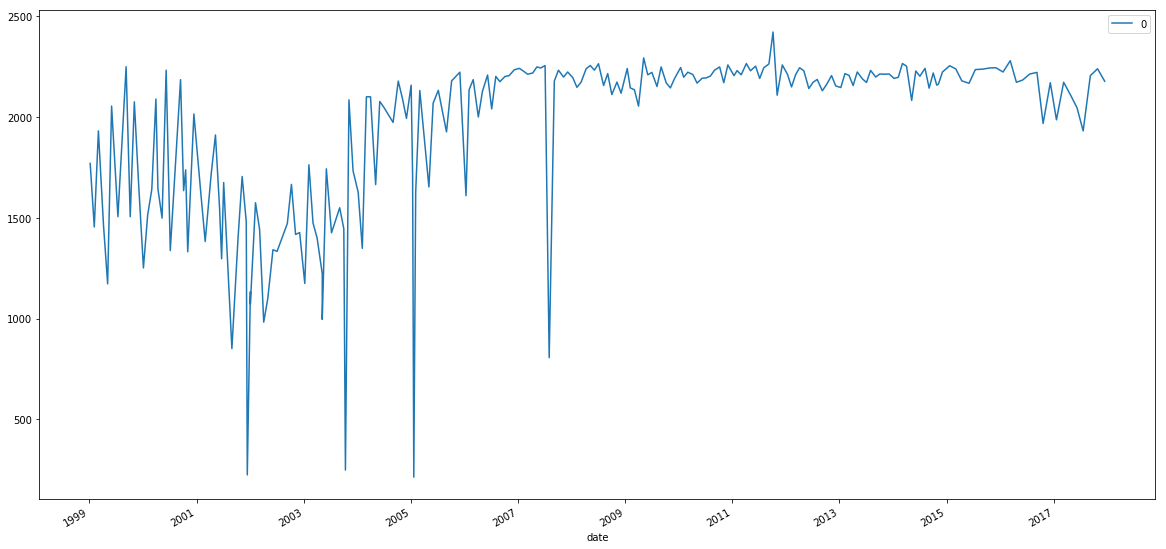

In [8]:
nr = range(217)
acac=[]
for x in nr:
    ababab = corpus[x].count(" ")
    
    acac.append(ababab)
    
# create DataFrame
datum = dataframe_preprocessed.date
abab = pd.DataFrame(acac, index = datum)

abab.plot(kind = 'line', figsize=(20,10))


,0
count,217.000000
mean,0.601773
std,0.015870
min,0.519101
25%,0.592644
50%,0.601501
75%,0.611347
max,0.661914


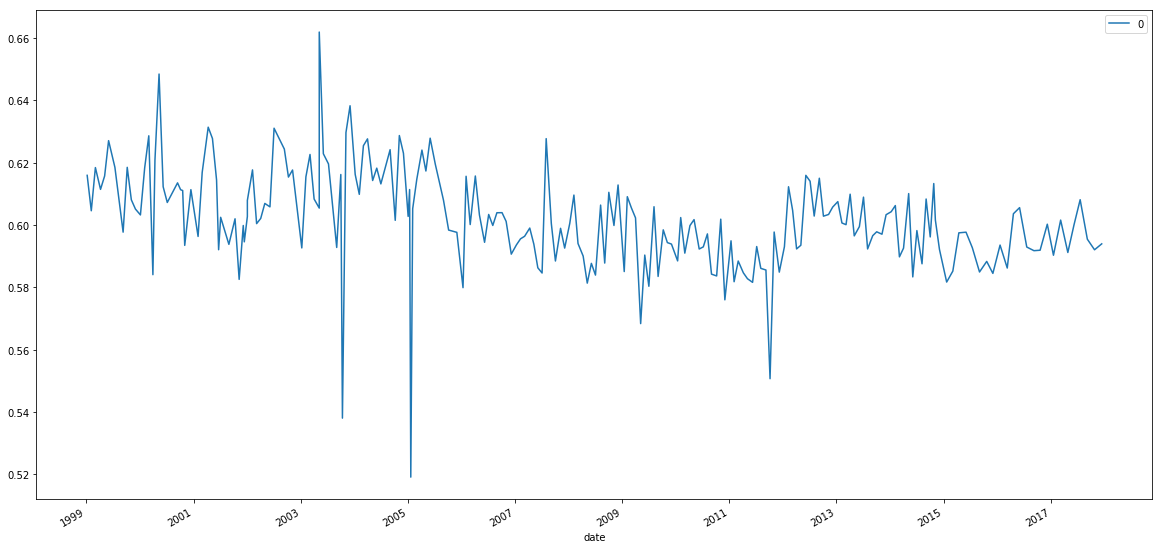

In [9]:
# development stopwords

nr_stop = ddd.sub(abab)
nr_stopperc = nr_stop.divide(ddd)
nr_stopperc.plot(kind = 'line', figsize=(20,10))

nr_stopperc.describe()


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(corpus) # tfidf = sparse csr-matrix
print(tfidf)



# tfidf matrix indicates importance of every term for document and corpus in order to distinguish documents across corpus 
# and themes across documents

NameError: name 'corpus' is not defined

In [11]:
words = tfidf_vectorizer.get_feature_names()

# get 25 most important terms of corpus:
feature_array = np.array(words)
tfidf_sorting = np.argsort(tfidf.toarray()).flatten()[::-1]
top_25 = feature_array[tfidf_sorting][:25]
print("Most important 25 terms: {}".format(top_25))

# get 25 most frequent words
vectorizer = CountVectorizer()
tf = vectorizer.fit_transform(corpus)
words1 = vectorizer.get_feature_names()
feature_array1 = np.array(words1)
tf_sorting = np.argsort(tf.toarray()).flatten()[::-1]
frequent_25 = feature_array1[tf_sorting][:25]
print("Most frequent 25 terms: {}".format(frequent_25))


# Below the 25 most important words indicated by the tfidf matrix are shown as well as the 25 most frequent words

Most important 25 terms: ['rate' 'gold' 'day' 'teeth' 'euro' 'exchang' 'payment' 'target'
 'euphoria' 'human' 'govern' 'forese' 'bank' 'system' 'council' 'settl'
 'januari' 'price' 'market' 'oper' 'develop' 'reserv' 'calendar'
 'interest' 'futur']
Most frequent 25 terms: ['rate' 'euro' 'govern' 'day' 'bank' 'exchang' 'council' 'price' 'market'
 'target' 'develop' 'system' 'interest' 'futur' 'today' 'time' 'issu'
 'polici' 'indic' 'januari' 'oper' 'forese' 'decis' 'ecb' 'like']


# 3) Derive topics from corpus via NMF

In [14]:
from sklearn.decomposition import NMF
import numpy as np


# Non-negative Matrix Factorization (NMF) allows to classify texts and leads to similar outputs as probablistic Latent
# Semantic Analysis. Comparing outputs containing different quanities of topics derived led to best results of regression 
# if _____ (currently 15)  topics are to be derived


model = NMF(n_components=15)

W = nmf = model.fit_transform(tfidf)        # W = Tocpics to document
H = model.components_                       # H = Terms to topic, factorization matrix
                       
    
date = dataframe_preprocessed.date
index = pd.DatetimeIndex(date)


idx_to_word = np.array(tfidf_vectorizer.get_feature_names())

for i, topic in enumerate(H):
 
    print("Topic {}: {}".format(i, ", ".join([str(x) for x in idx_to_word[topic.argsort()[-15:]]])))
    



# Currently the attribution for each row in W is not a percentage, but we want to assign each document to any topic which it can be at least 10% attributed to
sums = np.sum(W, axis=1)
W_percent = W / sums[:, None]


df = pd.DataFrame(W_percent, index)
df.head()


# Output describes most important words for determined topic. Below the W matrix is shown. W represents the percentage,
# to what extend a text consists of a certian topic



Topic 0: high, commod, rate, euro, economi, regard, medium, project, effect, market, expect, secondround, growth, inflat, price
Topic 1: price, financi, fiscal, polici, bond, countri, think, monetari, govern, market, ltro, ecb, bank, euro, omt
Topic 2: state, last, monetari, increas, govern, market, ecb, polici, intervent, growth, develop, exchang, price, rate, euro
Topic 3: condit, continu, support, time, eurozon, recoveri, asset, growth, measur, rate, programm, monetari, purchas, polici, inflat
Topic 4: measur, decid, market, fix, price, basi, oper, bank, take, point, tender, today, decis, interest, rate
Topic 5: fragment, remain, price, credit, market, subdu, bank, euro, forward, expect, time, low, guidanc, rate, inflat
Topic 6: govern, recoveri, interest, expect, develop, monetari, ecb, inflat, polici, price, year, econom, rate, euro, growth
Topic 7: expert, slide, provis, file, cbr, ncb, moscow, npl, capit, test, taci, billion, exercis, supervis, bank
Topic 8: econom, regard, anal

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
date,,,,,,,,,,,,,,,
2017-12-14,0.000000,0.0,0.000000,0.753480,0.000000,0.000000,0.000000,0.000000,0.000000,0.034215,0.139664,0.004988,0.051014,0.000000,0.016639
2017-10-26,0.000000,0.0,0.000000,0.665943,0.054732,0.000000,0.000000,0.060548,0.000000,0.029984,0.158637,0.000000,0.017920,0.012235,0.000000
2017-09-07,0.000000,0.0,0.106597,0.624801,0.086279,0.024751,0.023873,0.000000,0.000000,0.000000,0.099469,0.000000,0.034230,0.000000,0.000000
2017-07-20,0.016409,0.0,0.000000,0.637991,0.000000,0.043773,0.029473,0.000000,0.007160,0.018110,0.202755,0.013795,0.012829,0.000000,0.017705
2017-06-08,0.018959,0.0,0.000000,0.748699,0.040272,0.092290,0.000000,0.000000,0.031815,0.006976,0.000000,0.000000,0.060989,0.000000,0.000000


In [16]:
# If more than _____ (again comparing results to derive optimal value, currently 10% 'topic limit') percent of the text was
# devoted to a derived topic, it counted as mentioned. The code below counts the number of mentionings of the subsequent 
# topic per quarter.





# WICHTIG!!! Werte der Matrix müssen durch sich selbst geteilt werden, damit prozente ableitbar sind! (Github: https://github.com/ewellinger/election_analysis)
# Check percent_treshold in NMF clustering

#How many latent topics should we look for?
#Rundown of the challenges associated with trying to determine the number of topics to factorize into. Include nmf_similarity plot and give a rundown of the thinking behind it as well as the PCA scree plot that gives another approach to the same question.




def topic_selector(value):
    if value < 0.25:
        return 0
    else:
        return 1
        
        
def dataframe_topics(data, i):
    for cell in [i]:
        data[cell] = data[cell].apply(topic_selector)
  
    return data


ii = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
for i in ii:
    dfw = dataframe_topics(df,i)
# print(dfw.loc[:,dfw.any()]) #check if one topic has 0 mentions higher than 10% of text -> no, if columns are same amount

dfw = dfw.resample('Q',).sum().sort_index(ascending = False) # summarize mentions during quarter 
dfw.head()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
date,,,,,,,,,,,,,,,
2017-12-31,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2017-09-30,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2017-06-30,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2017-03-31,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
2016-12-31,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0


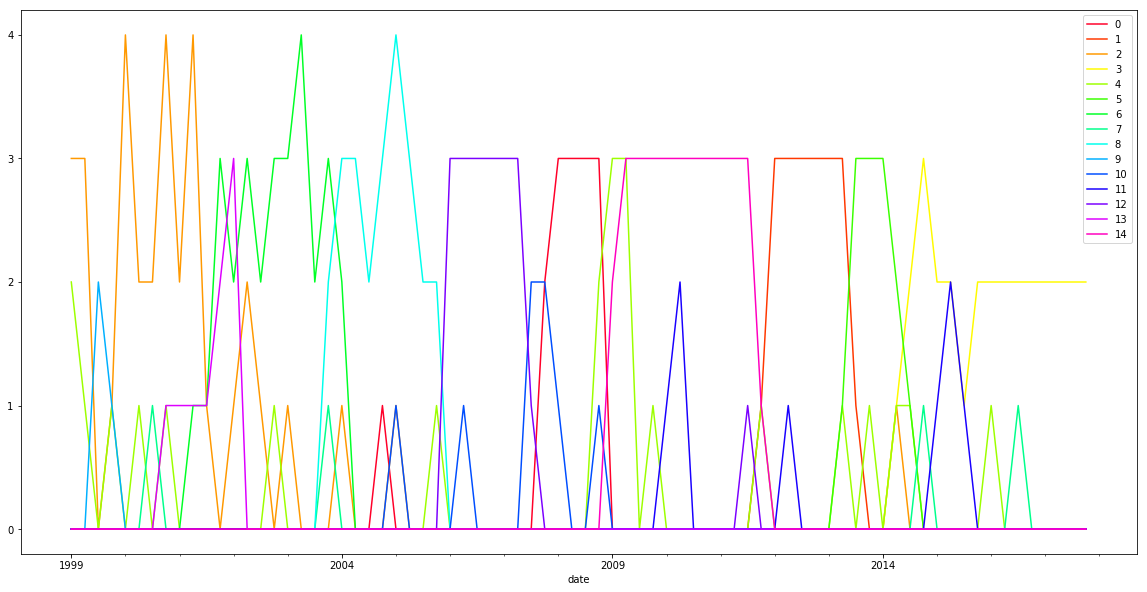

In [17]:
dfw.plot(kind='line', yticks=[0,1,2,3,4], colormap='gist_rainbow',figsize=(20,10))

In [18]:
print(dfw.sum())
dfw.describe()



0     15
1     20
2     34
3     29
4     23
5     13
6     29
7      4
8     24
9      3
10     8
11     8
12    20
13     9
14    33
dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,0.197368,0.263158,0.447368,0.381579,0.302632,0.171053,0.381579,0.052632,0.315789,0.039474,0.105263,0.105263,0.263158,0.118421,0.434211
std,0.712175,0.822491,0.998596,0.799452,0.653600,0.640586,0.951730,0.224781,0.897560,0.255123,0.385710,0.385710,0.822491,0.460930,1.037118
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,3.000000,4.000000,3.000000,3.000000,3.000000,4.000000,1.000000,4.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000


In [ ]:
# export matrix to excel file

writer = pd.ExcelWriter('AAAAA.xlsx')
dfw.to_excel(writer)
writer.save()

In [19]:
# variables for visulaization

# H and W
sums = np.sum(H, axis=1)
H_percent = H / sums[:, None]

print(type(H_percent))
print(H_percent.shape)

print(type(W_percent))
print(W_percent.shape)

length = np.asarray(acac)
print(type(length))
print(length.shape)

print(type(feature_array1))
print(feature_array1.shape)

TF = tf.toarray().transpose()
TFF = TF.sum(axis=1)
print(type(TFF))
print(TFF.shape)


<class 'numpy.ndarray'>
(15, 6200)
<class 'numpy.ndarray'>
(217, 15)
<class 'numpy.ndarray'>
(217,)
<class 'numpy.ndarray'>
(6200,)
<class 'numpy.ndarray'>
(6200,)


In [20]:
import pyLDAvis

graph = pyLDAvis.prepare(H_percent,W_percent, length, feature_array1, TFF, R=15)
pyLDAvis.display(graph)

C:\Users\Luca Poll\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Luca Poll\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Luca Poll\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Luca Poll\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [21]:
# yearly summarized number of mentions quarterly, topics with no metions deleted
dfw_annually = pd.read_excel('dfw_P_15_0-25_agg-current.xlsx', sheet_name='an', index_col=0)


# 4) Bulid DataFrames for dependent and independent variables

In [39]:
# 1) bulid DataFrame for independent variables

import statsmodels.api as sm

files = ['10_years_int_rate.xlsx','ea_debt.xlsx','euribor_int_rates.xlsx','exchange_rates.xlsx','gdp_growth.xlsx','m3_growth.xlsm','unemployment_rate.xlsx', 'time.xlsx']

dataframes = [pd.ExcelFile(f) for f in files]

intr = dataframes[0].parse('annually_aggregated')
debt = dataframes[1].parse('annually_aggregated')
euribor = dataframes[2].parse('annually_aggregated')
exch = dataframes[3].parse('annually_aggregated')
gdp = dataframes[4].parse('annually_aggregated')
m3 = dataframes[5].parse('annually_aggregated')
unempl = dataframes[6].parse('annually_aggregated')
time = dataframes[7].parse('Tabelle1')

frames = [intr] 
frames.append(euribor.delta_euriday_an)
frames.append(exch.delta_dollar_an) 
frames.append(gdp.delta_gdp_an) 
frames.append(m3.delta_m3_an) 
frames.append(time.fincri)
frames.append(time.year) 

# frames.append(debt.delta_debt_an)
# frames.append(euribor.delta_eurimon_an)
# frames.append(euribor.delta_euri3mon_an) 
# frames.append(euribor.delta_euri6mon_an)
# frames.append(euribor.delta_euri12mon_an) 
# frames.append(exch.delta_pound_an) 
# frames.append(exch.delta_franc_an) 
# frames.append(exch.delta_yen_an) 
# frames.append(unempl.delta_unempl_an)
# frames.append(time.qter) 



new_df = pd.concat(frames, axis=1)


ndf = new_df.set_index('quarter')
ndf = ndf.resample('Q').sum().sort_index(ascending = False)


masterframe = pd.concat([dfw_annually, ndf], axis = 1)
masterframe


# Prossible control variables are the quarterly data on annually aggregated changes in:

#    - 10 years interest rate (StatisticalDataWarehouse: IRS.M.U2.L.L40.CI.0000.EUR.N.Z) 
#    - Government debt (Eurostat: Quarterly government debt [gov_10q_ggdebt])
#    - euribor rates (Eurostat: Geldmarktzinssätze - Vierteljährliche Daten [irt_st_q])
#    - exchange rates [Pund Sterling, Swiss Franc, Yen, USD] (Eurostat: Euro/Ecu-Wechselkurse - Vierteljährliche Daten [ert_bil_eur_q])
#    - GDP (StatisticalDataWarehouse: MNA.Q.Y.I8.W2.S1.S1.B.B1GQ._Z._Z._Z.EUR.LR.GY)
#    - Money aggregate M3 (StatisticalDataWarehouse: BSI.Q.U2.N.V.M30.X.I.U2.2300.Z01.A)
#    - Unemployment rate (Eurostat: Unemployment by sex and age - quarterly average [une_rt_q])

#    - variable for year
#    - variable for quarter
#    - dummy for financial crisis 07/08

# due to strong correlations within the variables, most are excluded as shown in the next section.
# The ouput contains the mentions of the derived topics along with the selected controll variables. 




,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,...,topic12,topic13,topic14,delta_intr_an,delta_euriday_an,delta_dollar_an,delta_gdp_an,delta_m3_an,fincri,year
2017-12-31,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0.06,0.00,0.0985,2.550,5.025,0.0,2017.0
2017-09-30,0,0,0,8,0,0,0,0,0,0,...,0,0,0,0.50,-0.02,0.0580,2.350,5.125,0.0,2017.0
2017-06-30,0,0,0,8,0,0,0,1,0,0,...,0,0,0,0.21,-0.02,-0.0271,2.075,5.100,0.0,2017.0
2017-03-31,0,0,0,8,0,0,0,1,0,0,...,0,0,0,0.17,-0.09,-0.0372,1.875,5.100,0.0,2017.0
2016-12-31,0,0,0,8,0,0,0,1,0,1,...,0,0,0,-0.27,-0.19,-0.0164,1.775,5.075,0.0,2016.0
2016-09-30,0,0,0,8,0,0,0,1,0,1,...,0,0,0,-0.76,-0.22,0.0049,1.775,4.975,0.0,2016.0
2016-06-30,0,0,0,7,0,0,0,0,0,1,...,0,0,0,-0.39,-0.24,0.0239,1.850,4.850,0.0,2016.0
2016-03-31,0,0,0,7,0,0,0,0,0,1,...,0,0,0,0.02,-0.21,-0.0241,1.925,4.775,0.0,2016.0
2015-12-31,0,0,0,7,0,0,0,0,0,0,...,0,0,0,-0.31,-0.14,-0.1545,1.950,4.575,0.0,2015.0
2015-09-30,0,1,0,8,0,0,0,1,0,0,...,0,0,0,-0.43,-0.14,-0.2139,1.825,4.300,0.0,2015.0


In [47]:
masterframe_judg = masterframe.drop(masterframe.index[0:4])
masterframe_judg = masterframe_judg.reset_index()
masterframe_judg = masterframe_judg.drop('index', axis=1)
masterframe_judg

ndf_judg = ndf.drop(ndf.index[0:4])
ndf_judg = ndf_judg.reset_index()
ndf_judg = ndf_judg.drop('quarter', axis=1)
ndf_judg

,delta_intr_an,delta_euriday_an,delta_dollar_an,delta_gdp_an,delta_m3_an,fincri,year
0,-0.27,-0.19,-0.0164,1.775,5.075,0.0,2016.0
1,-0.76,-0.22,0.0049,1.775,4.975,0.0,2016.0
2,-0.39,-0.24,0.0239,1.850,4.850,0.0,2016.0
3,0.02,-0.21,-0.0241,1.925,4.775,0.0,2016.0
4,-0.31,-0.14,-0.1545,1.950,4.575,0.0,2015.0
5,-0.43,-0.14,-0.2139,1.825,4.300,0.0,2015.0
6,-0.95,-0.29,-0.2658,1.625,3.750,0.0,2015.0
7,-1.64,-0.23,-0.2435,1.425,2.975,0.0,2015.0
8,-1.46,-0.14,-0.1112,1.350,2.150,0.0,2014.0
9,-1.02,-0.07,0.0014,1.175,1.475,0.0,2014.0


In [51]:
# 2) bulid Dataframe for dependent variable


spf_errs = pd.read_excel('SPF_errors.xlsx', sheet_name = 'data')
spf_errs = spf_errs.set_index('quarter')
spf_errs = spf_errs.resample('Q').sum().sort_index(ascending = False)
spf_errs = spf_errs[:68]
spf_errs24 = spf_errs.err_24_month[:72]


# ABSOLUTE VALUES
spf_errs = spf_errs.abs()
spf_errs





# DataFrame shows the quarterly inflation forecast error of SPF 12 and 24 month rolling forecast.
# The HICP inflation is taken from the ECBs StatisticalDataWarehouse (ICP.M.U2.N.000000.3.ANR),
# as well as the SPF 12 month rolling forecast (SPF.M.U2.HICP.POINT.P12M.Q.AVG) and the 24 month rolling forecast
# (SPF.M.U2.HICP.POINT.P24M.Q.AVG)

,err_12_month,err_24_month
quarter,,
2017-12-31,0.02,0.11
2017-09-30,0.29,0.03
2017-06-30,0.16,0.24
2017-03-31,0.40,0.06
2016-12-31,0.05,0.12
2016-09-30,0.70,0.97
2016-06-30,1.11,1.39
2016-03-31,0.98,1.45
2015-12-31,0.56,1.33


In [52]:
spf_errs_judg = spf_errs.reset_index()
spf_errs_judg = spf_errs_judg.drop('quarter', axis=1)
spf_errs_judg

,err_12_month,err_24_month
0,0.02,0.11
1,0.29,0.03
2,0.16,0.24
3,0.40,0.06
4,0.05,0.12
5,0.70,0.97
6,1.11,1.39
7,0.98,1.45
8,0.56,1.33
9,1.17,1.77


# 5) Correlation

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
topic0,1.000000,-0.132908,-0.162312,-0.161227,0.017263,-0.105301,-0.148314,-0.178988,-0.047207,-0.151597,0.760924,-0.129228,-0.040586,-0.113745,-0.100688
topic1,-0.132908,1.000000,-0.191507,-0.083609,0.107424,0.000557,-0.179930,-0.107736,-0.156676,-0.179691,-0.151223,-0.048552,-0.100147,-0.134824,0.286809
topic2,-0.162312,-0.191507,1.000000,-0.220794,-0.244666,-0.092621,0.195189,0.273039,-0.087905,0.679364,-0.193738,-0.191653,-0.189637,0.527605,-0.150399
topic3,-0.161227,-0.083609,-0.220794,1.000000,-0.231668,0.091928,-0.218268,0.437517,-0.190059,-0.132373,-0.183445,0.382778,-0.179562,-0.163551,-0.142172
topic4,0.017263,0.107424,-0.244666,-0.231668,1.000000,-0.151308,-0.218121,-0.257189,-0.189930,-0.122778,-0.045830,0.291797,-0.142431,-0.163441,-0.142871
topic5,-0.105301,0.000557,-0.092621,0.091928,-0.151308,1.000000,-0.142556,0.034519,-0.124132,-0.142367,-0.119812,-0.060061,-0.117277,-0.106819,0.242812
topic6,-0.148314,-0.179930,0.195189,-0.218268,-0.218121,-0.142556,1.000000,0.088704,0.041124,0.147394,-0.172717,-0.174949,-0.169062,0.448213,-0.136312
topic7,-0.178988,-0.107736,0.273039,0.437517,-0.257189,0.034519,0.088704,1.000000,0.016054,0.114396,-0.203653,0.058938,-0.199343,-0.045392,-0.160727
topic8,-0.047207,-0.156676,-0.087905,-0.190059,-0.189930,-0.124132,0.041124,0.016054,1.000000,-0.163450,-0.130778,-0.152338,-0.056485,-0.134086,-0.118694
topic9,-0.151597,-0.179691,0.679364,-0.132373,-0.122778,-0.142367,0.147394,0.114396,-0.163450,1.000000,-0.172488,-0.084862,-0.168838,0.069901,-0.136131


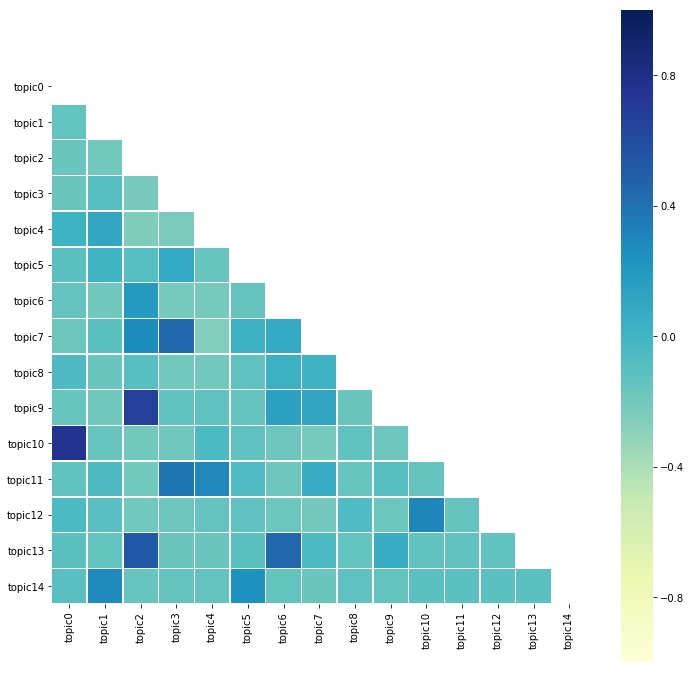

In [53]:
# correlation among topics
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,12))
mask = np.zeros_like(dfw_annually.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data=dfw_annually.corr(),mask=mask,vmin=-1, vmax=1, square=True, cmap="YlGnBu",linewidths=.5, ax=ax)
dfw_annually.corr()

AxesSubplot(0.241667,0.125;0.503333x0.755)


,delta_intr_an,delta_euriday_an,delta_dollar_an,delta_gdp_an,delta_m3_an,fincri,year
delta_intr_an,1.000000,0.376454,0.136204,0.480582,0.234752,0.241925,-0.229416
delta_euriday_an,0.376454,1.000000,0.054757,0.840554,0.082084,0.237641,-0.110164
delta_dollar_an,0.136204,0.054757,1.000000,0.050760,0.363854,0.306931,-0.186388
delta_gdp_an,0.480582,0.840554,0.050760,1.000000,0.341394,0.232100,-0.267359
delta_m3_an,0.234752,0.082084,0.363854,0.341394,1.000000,0.621812,-0.461888
fincri,0.241925,0.237641,0.306931,0.232100,0.621812,1.000000,-0.068147
year,-0.229416,-0.110164,-0.186388,-0.267359,-0.461888,-0.068147,1.000000


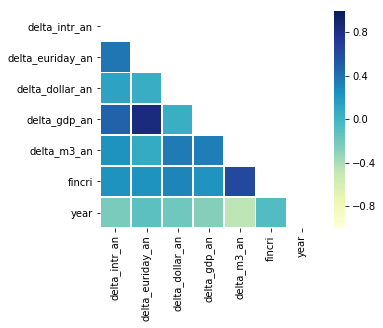

In [54]:
# correlation among control variables

mask = np.zeros_like(ndf.corr())
mask[np.triu_indices_from(mask)] = True
print(sns.heatmap(data=ndf.corr(), mask=mask, vmin=-1, vmax=1, square=True, cmap="YlGnBu",linewidths=.5))
ndf.corr()

# correlations among control variables (>0,5):

# intr, euri6.        0,50                       # euriday, eurimon:   0,99
# intr, euri12:       0,57                       # euriday, euri3mon:  0,98
                                                 # euriday, euri6mon:  0,96
# debt, euriday:      0.65                       # euriday, euri12mon: 0,92
# debt, eurimon:      0,63                       # euriday, gdp:       0,84
# debt, euri3mon:     0,63                       # euriday, unempl:   -0,77
# debt, euri6mon:     0,63                       # eurimon, euri3:     0,99
# debt, euri12mon:    0,57                       # eurimon, euri6:     0,98
# debt, gdp:         -0,71                       # eurimon, euri12:    0,95
# debt, unempl:       0,79                       # eurimon, gdp:       0,86
                                                 # eurimon, unempl:   -0,78
# franc, yen:         0,56                       # eurimon3, euri6:    0,99
# franc, dollar:      0,55                       # eurimon3, euri12:   0,97
# yen, dollar:        0,62                       # eurimon3, gdp:      0,87
                                                 # eurimon3, unempl:  -0,78
# gdp, unempl:       -0,88                       # euri6, euri12:      0,99
                                                 # euri6, gdp:         0,86
# m3, ficri:          0,62                       # euri6, unempl:     -0,77
                                                 # euri12, gdp:        0,84
                                                 # euri12, unempl:    -0,75
        

,const,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,...,topic12,topic13,topic14,delta_intr_an,delta_euriday_an,delta_dollar_an,delta_gdp_an,delta_m3_an,fincri,year
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
topic0,NaN,1.000000,-0.132908,-0.162312,-0.161227,0.017263,-0.105301,-0.148314,-0.178988,-0.047207,...,-0.040586,-0.113745,-0.100688,0.016953,-0.218382,0.014880,-0.166908,0.420444,0.585604,-0.032271
topic1,NaN,-0.132908,1.000000,-0.191507,-0.083609,0.107424,0.000557,-0.179930,-0.107736,-0.156676,...,-0.100147,-0.134824,0.286809,-0.206575,-0.084861,-0.277143,-0.245519,-0.387126,-0.140329,0.294061
topic2,NaN,-0.162312,-0.191507,1.000000,-0.220794,-0.244666,-0.092621,0.195189,0.273039,-0.087905,...,-0.189637,0.527605,-0.150399,0.103834,0.284663,-0.177404,0.391539,0.045191,-0.179781,-0.666479
topic3,NaN,-0.161227,-0.083609,-0.220794,1.000000,-0.231668,0.091928,-0.218268,0.437517,-0.190059,...,-0.179562,-0.163551,-0.142172,-0.138965,0.013915,-0.274410,0.137685,-0.142227,-0.170230,0.683042
topic4,NaN,0.017263,0.107424,-0.244666,-0.231668,1.000000,-0.151308,-0.218121,-0.257189,-0.189930,...,-0.142431,-0.163441,-0.142871,0.170785,-0.297642,-0.097344,-0.447607,-0.537894,-0.148850,0.158434
topic5,NaN,-0.105301,0.000557,-0.092621,0.091928,-0.151308,1.000000,-0.142556,0.034519,-0.124132,...,-0.117277,-0.106819,0.242812,-0.336989,0.046200,-0.046602,-0.095286,-0.371629,-0.111181,0.331207
topic6,NaN,-0.148314,-0.179930,0.195189,-0.218268,-0.218121,-0.142556,1.000000,0.088704,0.041124,...,-0.169062,0.448213,-0.136312,-0.110841,-0.302274,0.434795,-0.050369,0.294103,-0.160275,-0.502421
topic7,NaN,-0.178988,-0.107736,0.273039,0.437517,-0.257189,0.034519,0.088704,1.000000,0.016054,...,-0.199343,-0.045392,-0.160727,-0.117372,0.172981,-0.243688,0.227287,-0.056184,-0.188982,0.038636
topic8,NaN,-0.047207,-0.156676,-0.087905,-0.190059,-0.189930,-0.124132,0.041124,0.016054,1.000000,...,-0.056485,-0.134086,-0.118694,-0.097724,0.067760,0.096993,0.105757,0.214435,-0.139561,-0.283664


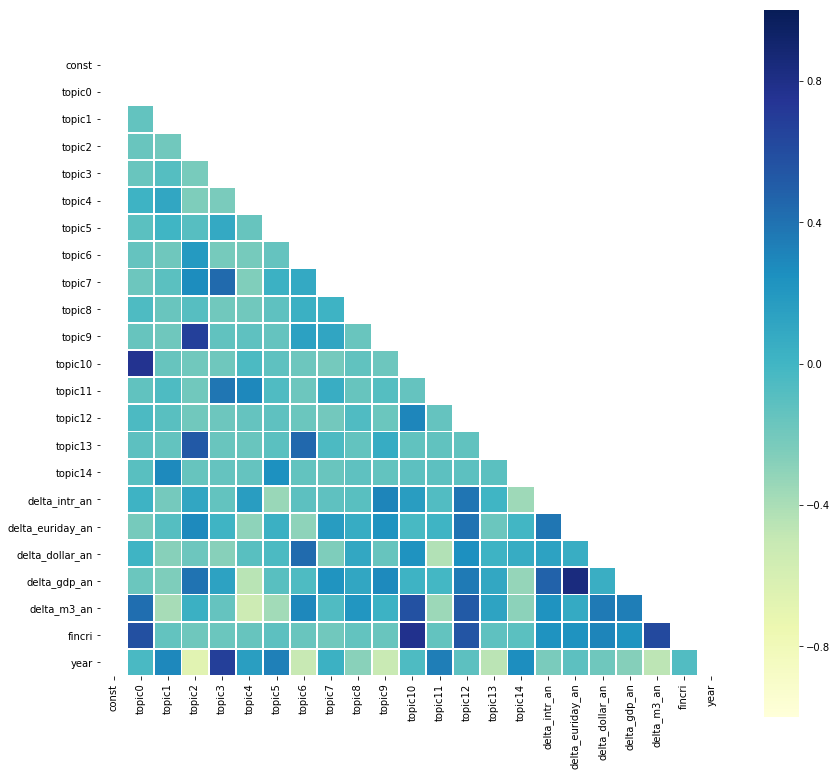

In [55]:
# correlation between topics and controll variables

mask = np.zeros_like(masterframe.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(14,13))
sns.heatmap(data=masterframe.corr(), mask=mask, vmin=-1, vmax=1, square=True, cmap="YlGnBu",linewidths=.9, ax=ax)

masterframe.corr()


# 6) Run regression

In [57]:
# OLS 12 month rolling forecast error
masterframe_judg = sm.add_constant(masterframe_judg)
model = sm.OLS(spf_errs_judg.err_12_month, masterframe_judg)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           err_12_month   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     5.673
Date:                Wed, 17 Oct 2018   Prob (F-statistic):           4.42e-07
Time:                        13:08:55   Log-Likelihood:                -10.022
No. Observations:                  68   AIC:                             66.04
Df Residuals:                      45   BIC:                             117.1
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              135.3464    164.408  